## Filling out missing user data

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render
import pytest

In [ ]:
#| hide
load_env()

True

In [ ]:
from stringdale import Define,V,E, Condition
from stringdale.chat import Chat

from pydantic import BaseModel,Field
from typing import Optional

In [ ]:
class User(BaseModel):
    name: Optional[str] = Field(None, description='The name of the user')
    age: Optional[int] = Field(None, description='The age of the user')
    email: Optional[str] = Field(None, description='The email of the user')


In [ ]:
ask_missing_data = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant asks the user for missing information.
        Do not ask for keys if they are not a part of the missing keys
        Ask the user for the following missing keys:
        {{missing_keys}}
        '''}])

format_new_info = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that gets user data and makes sure it is complete.
        If you are not sure that you were given the relevant information, put None in the relevant field.
        Fill part of the missing keys based on the user data.
        If the user didnt provide info an a given missing key, leave it empty
        
        {% if current_info %}
        The information we have so far is:
        {{current_info}}
        {% endif %}
        The missing keys are:
        {{missing_keys}}
        '''},
        {'role':'user','content':'{{input}}'},
        
    ],
    output_schema=User)

In [ ]:
class MissingKeys():
    def __init__(self,keys):
        self.keys = keys

    def get_missing_keys(self,obj):
        return [key for key in self.keys if getattr(obj,key,None) is None]

    def has_missing_keys(self,obj):
        return len(self.get_missing_keys(obj)) > 0

missing = MissingKeys(['name','age'])

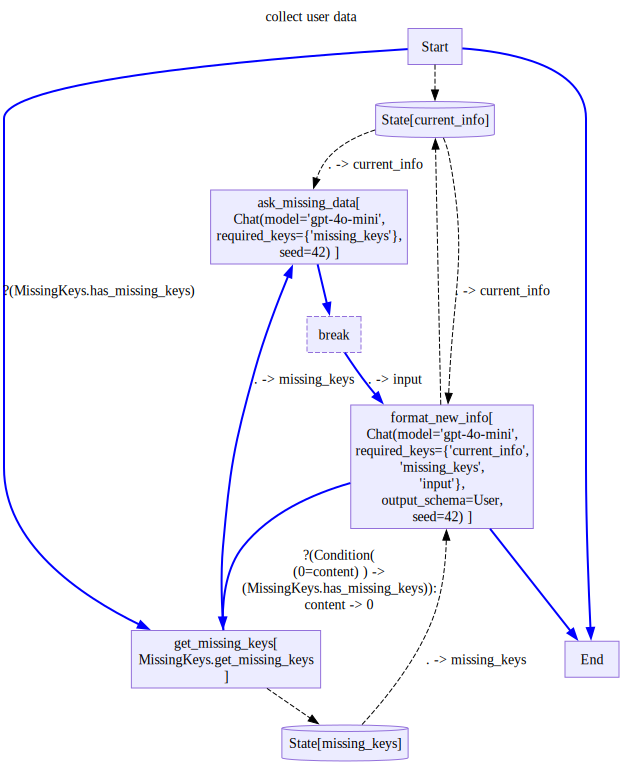

In [ ]:
with Define('collect user data',type='decision') as UserQA:
    V('Start',
        outputs=[
            ('get_missing_keys',missing.has_missing_keys),
            ('End',),
            ('state/current_info',)
        ])

    V('get_missing_keys',missing.get_missing_keys,
        outputs=[
            'ask_missing_data(missing_keys)',
            'state/missing_keys'

        ])

    V('ask_missing_data',ask_missing_data,
        inputs=['state/current_info(current_info)'],
        outputs=['break']    )

    V('break',is_break=True,outputs=['format_new_info(input)'])

    
    V('format_new_info',format_new_info,
        inputs=[
            'state/current_info(current_info)',
            'state/missing_keys(missing_keys=.)'
        ],
        outputs=[
            ('get_missing_keys(0=content)',Condition(missing.has_missing_keys,'(0=content)')),
            'End',
            'state/current_info'
        ])

UserQA.draw(direction='TB')


In [ ]:
d = UserQA()

for trace in d.run(None):
    trace.pprint()
d.output

{'role': 'assistant',
 'content': 'Could you please provide your name and age?',
 'meta': {'input_tokens': 50, 'output_tokens': 9}}

In [ ]:
for trace in d.run('my name is brian'):
    trace.pprint()
d.output

{'role': 'assistant',
 'content': 'Could you please provide your age?',
 'meta': {'input_tokens': 47, 'output_tokens': 7}}

In [ ]:
for trace in d.run('25 yo'):
    trace.pprint()
d.output

{'role': 'assistant',
 'content': User(name='brian', age=25, email=None),
 'meta': {'input_tokens': 383, 'output_tokens': 23}}